# 00 | Exploratory Data Analysis

**Objective:**
To explore and visualise the structure, distributions, and relationships in the credit risk dataset, with the goals of:
- Understanding the shape and composition of the data.
- Examining the distribution of numerical and categorical variables.
- Assessing class imbalance in the target variable (SeriousDlqin2yrs).
- Identifying potential outliers, skewness, and data quality issues
- Exploring relationships between features and the target variable
- Detecting multicollinearity and redundant features that may affect modeling

In [ ]:
import sys
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../src'))
from eda_baseline import load_data, load_cleaned_data, eda_overview, plot_distributions
from eda_missing import missing_values_summary, plot_missing_heatmap, missing_vs_target
from eda_outliers import plot_eda, iqr_outlier_summary
from eda_target_analysis import plot_numeric_distributions, print_skewness, plot_target_distribution, plot_numeric_by_target, plot_correlation_matrix, detect_multicollinearity

## Load Raw Dataset  
We’ll pull from our `credit_risk_raw` table in the SQLite DB.

In [ ]:
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_raw", conn)
conn.close()
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Raw Dataset Overview

In [ ]:
eda_overview(df)

Shape: (150000, 12)

Columns:
 Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

ℹInfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5

### Raw Dataset Observations
- Shape: 150,000 rows x 27 columns
- Target column: SeriousDlqin2yrs (binary: 1 = default, 0 = no default)
- `MonthlyIncome` has approximately 30k missing entries (20%)
- `NumberOfDependents` has approximately 3.9k missing (2.6%)
- Several fields have suspiciously large max values:
  - `DebtRatio`: up to 329,664
  - `RevolvingUtilizationOfUnsecuredLines`: up to 50,708
- `age` has minimum value of 0 → likely invalid


## Missing Values Analysis

We explore the extent and pattern of missing data to inform cleaning and modeling strategies.

Missing values summary:
                     missing_count  missing_pct
MonthlyIncome               29731    19.820667
NumberOfDependents           3924     2.616000


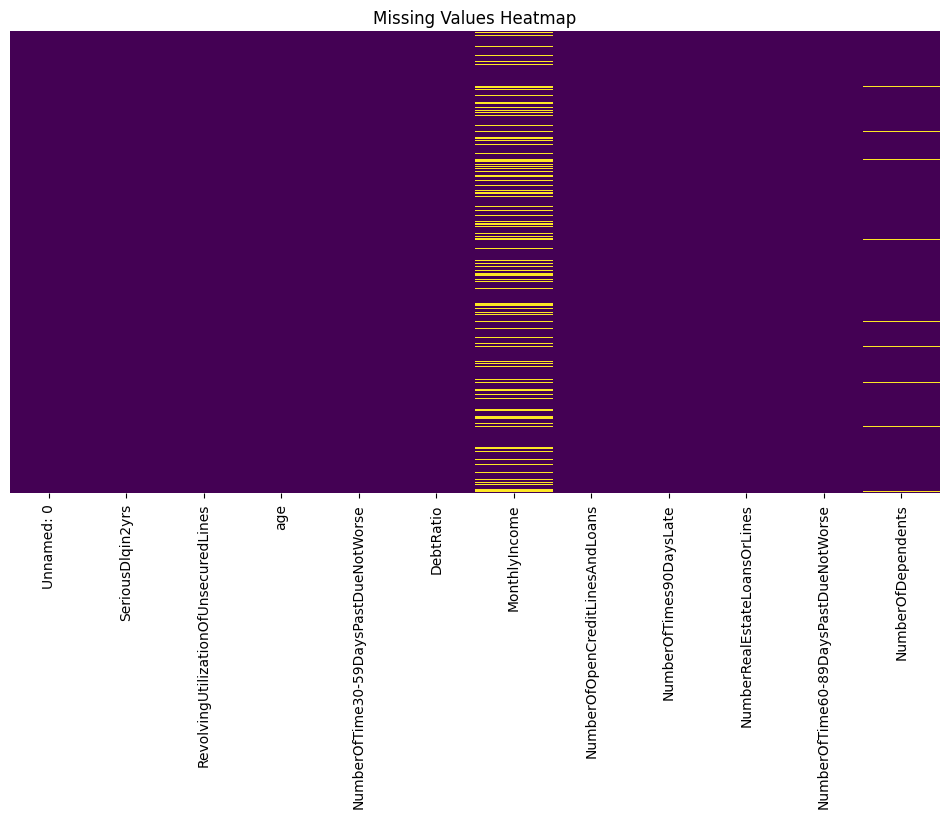


Target mean by missingness in MonthlyIncome:
 MonthlyIncome_missing_flag
0    0.069486
1    0.056137
Name: SeriousDlqin2yrs, dtype: float64

Target mean by missingness in NumberOfDependents:
 NumberOfDependents_missing_flag
0    0.067410
1    0.045617
Name: SeriousDlqin2yrs, dtype: float64


In [ ]:
missing_summary = missing_values_summary(df)
missing_summary[missing_summary['missing_count'] > 0]
plot_missing_heatmap(df)
missing_vs_target(df, target_col='SeriousDlqin2yrs')

### Missing Values Interpretation

- Missingness in both `MonthlyIncome` and `NumberOfDependents` is **informative** and correlates with a lower risk of default.
- This suggests the missing data is **not completely random**.
- As such, missing flags were created to retain missingness information.
- Missing values were imputed using median values in the preprocessing step (see `src/eda_missing.py`).

This approach helps preserve valuable signal from missingness for downstream modeling.

## Load Imputed Dataset  
We’ll pull from our `credit_risk_imputed` table in the SQLite DB.

In [ ]:
conn = sqlite3.connect("../data/loanvet.db")
df_imputed = pd.read_sql_query("SELECT * FROM credit_risk_imputed", conn)
conn.close()
df_imputed.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_missing_flag,NumberOfDependents_missing_flag
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0,0


## Feature Distributions

We visualise the distributions of numeric features to understand their range, central tendency, and shape.
Skewness is examined to identify variables that may benefit from transformation.

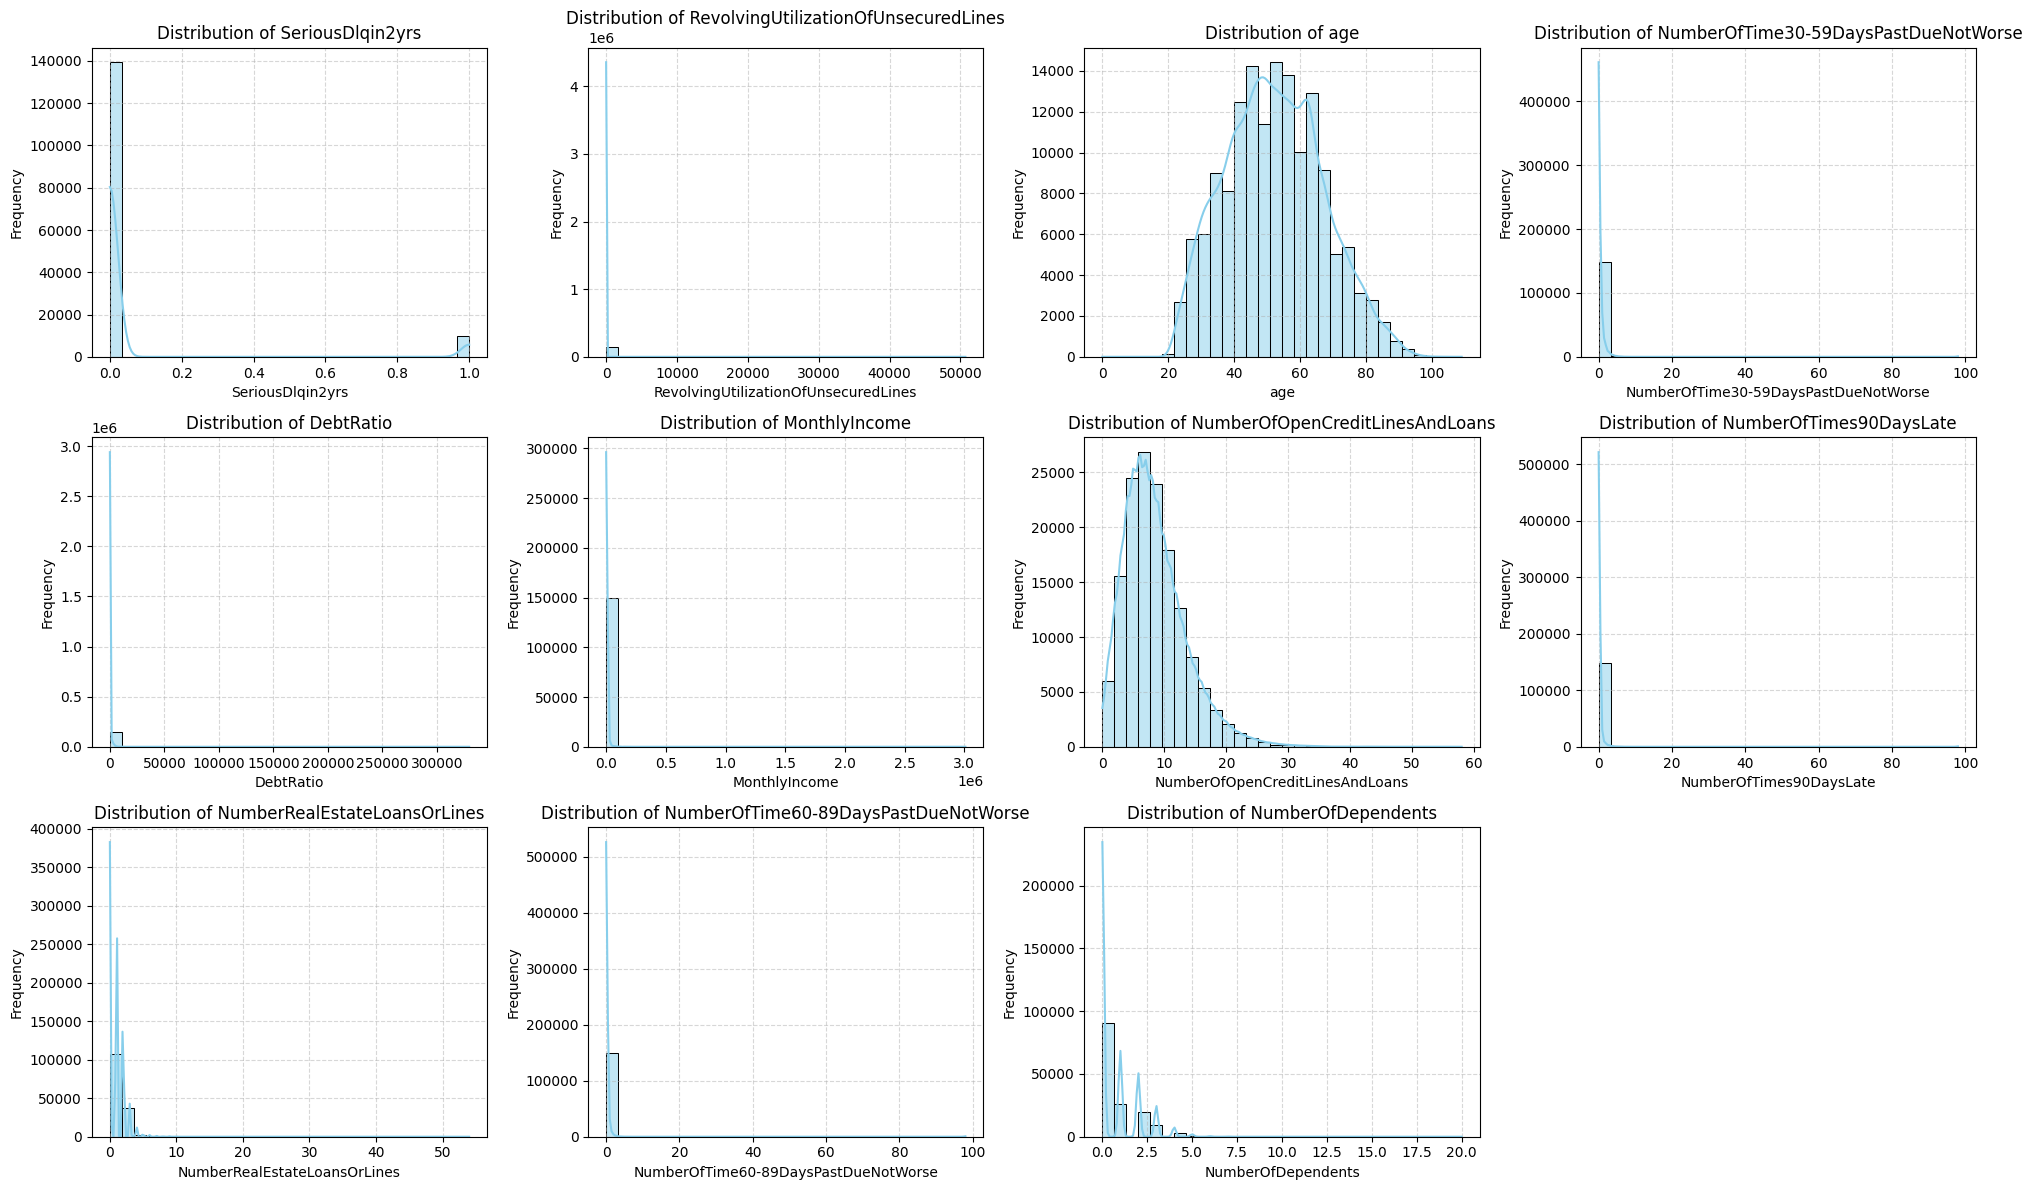

Skewness of numeric features:
 MonthlyIncome                           126.890468
RevolvingUtilizationOfUnsecuredLines     97.433211
DebtRatio                                94.979721
NumberOfTime60-89DaysPastDueNotWorse     25.424388
NumberOfTimes90DaysLate                  25.107372
NumberOfTime30-59DaysPastDueNotWorse     24.474608
NumberOfDependents_missing_flag           6.004405
NumberRealEstateLoansOrLines              3.484705
SeriousDlqin2yrs                          3.463772
NumberOfDependents                        1.620289
MonthlyIncome_missing_flag                1.534817
NumberOfOpenCreditLinesAndLoans           1.221834
age                                       0.192258
dtype: float64


In [ ]:
plot_numeric_distributions(df_imputed)
print_skewness(df_imputed)

### Feature Distribution Observations

- Several features exhibit **extreme positive skewness**, including:
  - `MonthlyIncome` (126.89)
  - `RevolvingUtilizationOfUnsecuredLines` (97.43)
  - `DebtRatio` (94.98)  
  These indicate highly right-tailed distributions with many low values and some extreme outliers.

- Delinquency-related features also show strong skewness:
  - `NumberOfTime60-89DaysPastDueNotWorse` (25.42)
  - `NumberOfTimes90DaysLate` (25.11)
  - `NumberOfTime30-59DaysPastDueNotWorse` (24.47)  
  Reflecting the rarity but significant impact of late payments.

- Moderate skewness is observed for:
  - `NumberOfDependents_missing_flag` (6.00)
  - `NumberRealEstateLoansOrLines` (3.48)

- The target variable `SeriousDlqin2yrs` has skewness of 3.46, indicating class imbalance.

- Features like `age` (0.19), `NumberOfOpenCreditLinesAndLoans` (1.22), and `NumberOfDependents` (1.62) have low skewness, closer to symmetric distributions.

**Implication:**  
The high skewness of several features suggests applying transformations such as log transforms to reduce skewness, stabilize variance, and improve model performance.


## Target Variable Distribution

We visualise and describe the distribution of the target variable.

Target variable 'SeriousDlqin2yrs' distribution (counts and proportions):
                   count  proportion
SeriousDlqin2yrs                    
0                 139382    0.933001
1                  10009    0.066999


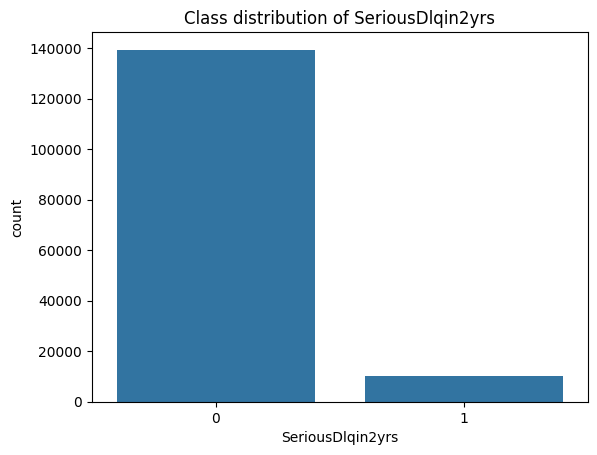

In [ ]:
plot_target_distribution(df_imputed)

### Target Value Distribution Observation

The dataset is highly imbalanced, with the majority class (no serious delinquency) making up over 93% of the data, while the minority class (serious delinquency) accounts for less than 7%. This imbalance should be considered when selecting evaluation metrics and modeling approaches.

## Outlier Analysis

We detect and analyse outliers in key numeric features using methods like IQR or Z-score.

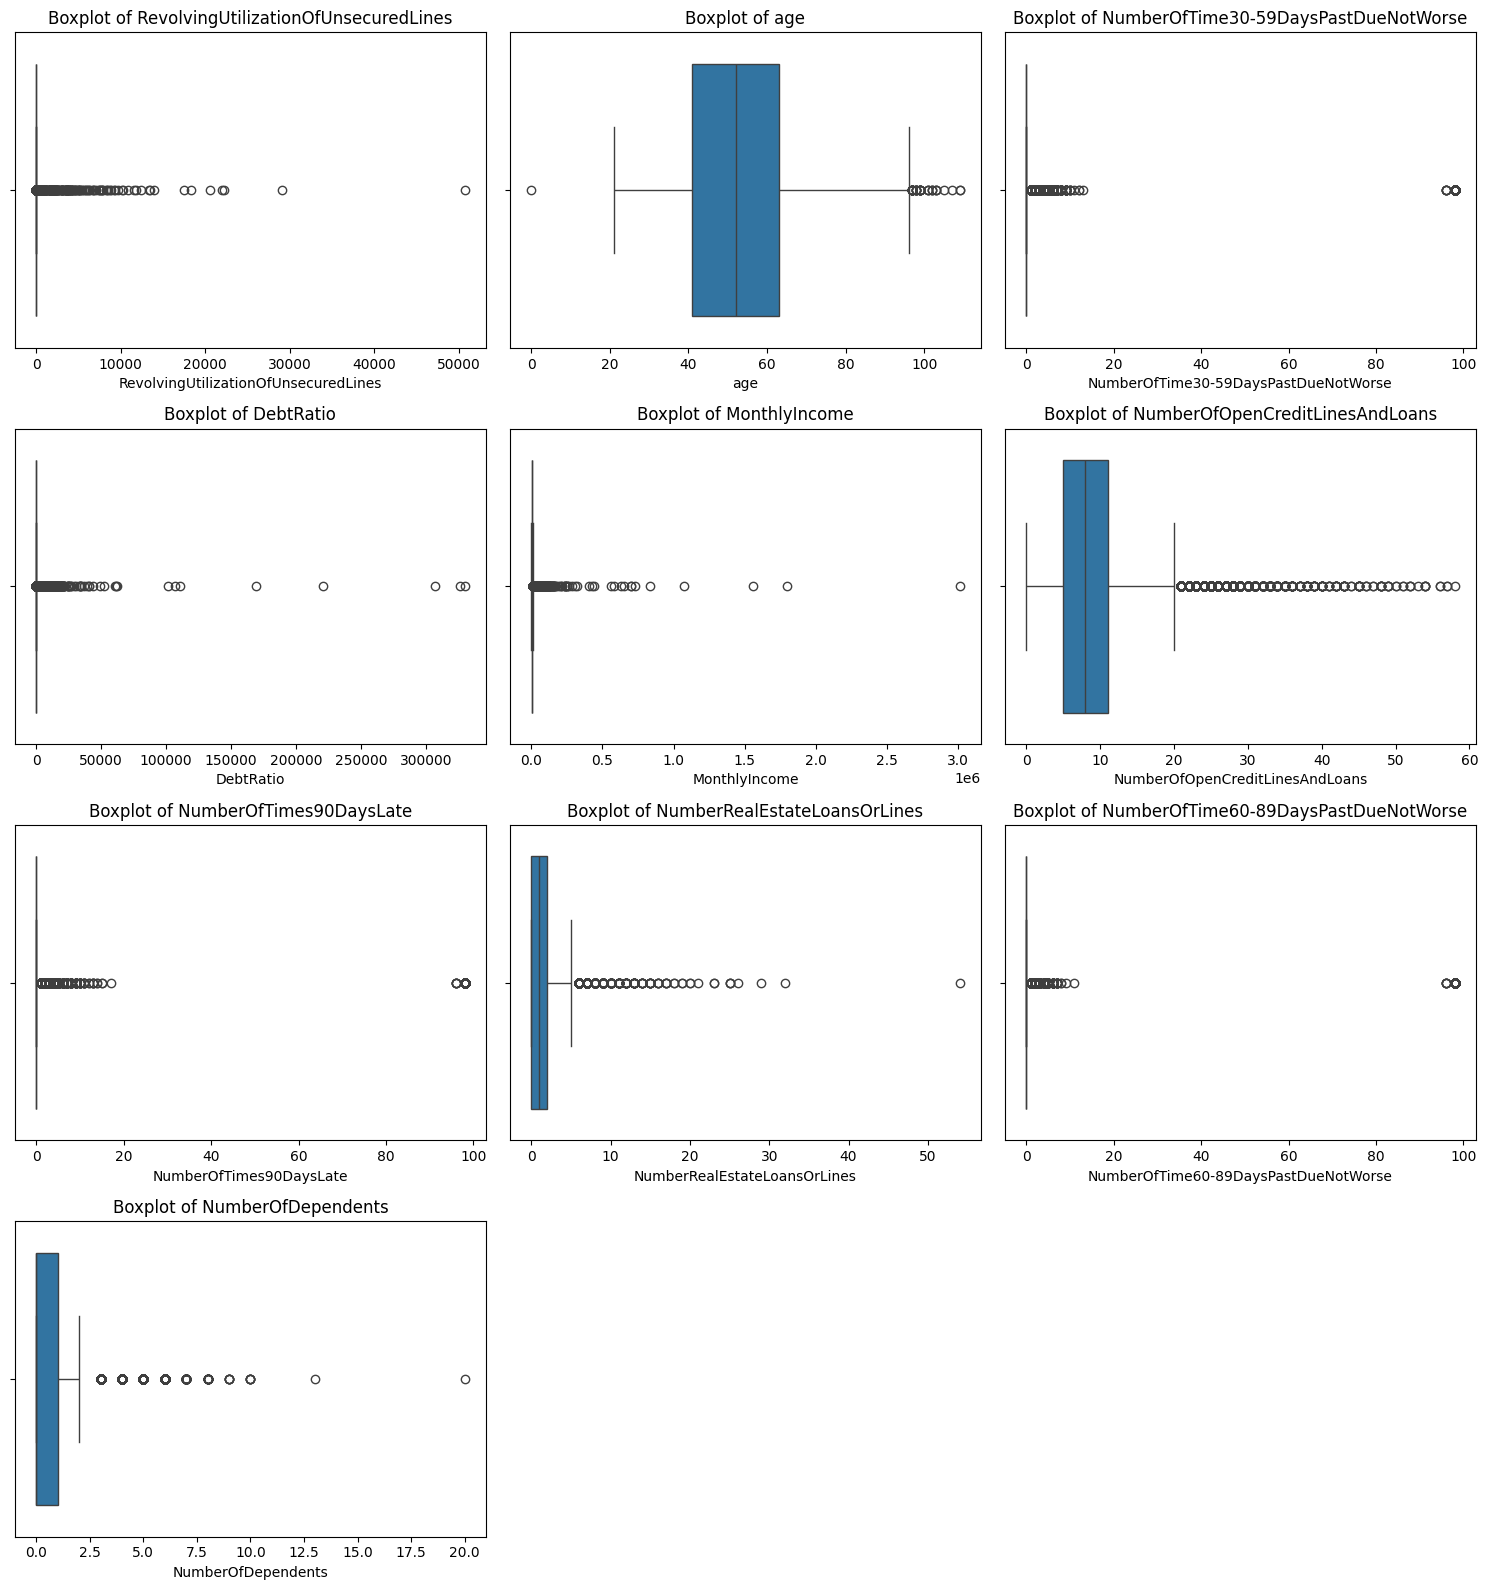

/Users/fan/loanvet/src/eda_outliers.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['0', '1'])
/Users/fan/loanvet/src/eda_outliers.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['0', '1'])
/Users/fan/loanvet/src/eda_outliers.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['0', '1'])


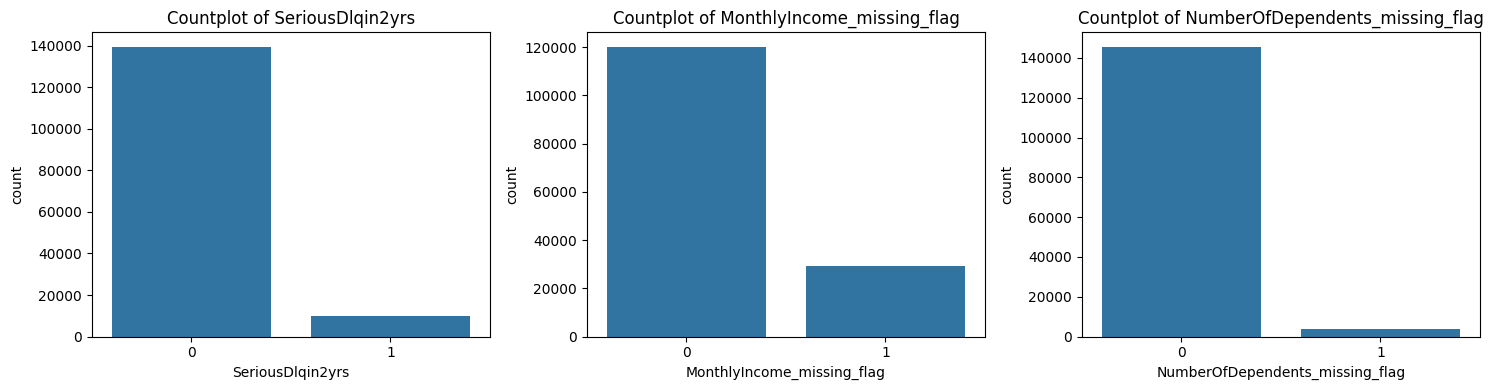

SeriousDlqin2yrs: 10009 outliers (6.70%)
RevolvingUtilizationOfUnsecuredLines: 769 outliers (0.51%)
age: 45 outliers (0.03%)
NumberOfTime30-59DaysPastDueNotWorse: 23938 outliers (16.02%)
DebtRatio: 31285 outliers (20.94%)
MonthlyIncome: 9141 outliers (6.12%)
NumberOfOpenCreditLinesAndLoans: 3980 outliers (2.66%)
NumberOfTimes90DaysLate: 8283 outliers (5.54%)
NumberRealEstateLoansOrLines: 793 outliers (0.53%)
NumberOfTime60-89DaysPastDueNotWorse: 7560 outliers (5.06%)
NumberOfDependents: 13336 outliers (8.93%)
MonthlyIncome_missing_flag: 29221 outliers (19.56%)
NumberOfDependents_missing_flag: 3828 outliers (2.56%)


In [ ]:
plot_eda(df_imputed)
iqr_outlier_summary(df_imputed)

## Outlier Analysis Summary

- A notable portion of the dataset exhibits outliers across several features, based on the IQR method (1.5 * IQR):

- **Target variable:**
  - `SeriousDlqin2yrs` has **10,009 outliers (6.70%)**, reflecting that a minority of the population defaulted on their loans.

- **Financial and credit behavior features with high outlier percentages:**
  - `NumberOfTime30-59DaysPastDueNotWorse`: 23,938 outliers (16.02%)
  - `DebtRatio`: 31,285 outliers (20.94%)
  - `MonthlyIncome_missing_flag`: 29,221 outliers (19.56%)
  - `MonthlyIncome`: 9,141 outliers (6.12%)
  - `NumberOfDependents`: 13,336 outliers (8.93%)
  - `NumberOfTimes90DaysLate`: 8,283 outliers (5.54%)
  - `NumberOfDependents_missing_flag`: 3,828 outliers (2.56%)

- **Features with moderate to low outlier presence:**
  - `NumberOfOpenCreditLinesAndLoans`: 3,980 outliers (2.66%)
  - `NumberOfTime60-89DaysPastDueNotWorse`: 7,560 outliers (5.06%)
  - `NumberRealEstateLoansOrLines`: 793 outliers (0.53%)
  - `age`: 44 outliers (0.03%)
  - `RevolvingUtilizationOfUnsecuredLines`: 0 outliers (0.00%)

**Interpretation:**  
The substantial outliers in debt-related and delinquency features suggest a highly skewed and heavy-tailed distribution in borrowers’ credit behaviors. Outlier handling is crucial to prevent these extreme values from unduly influencing model training, especially for variables like `DebtRatio` and delinquency counts.

Features such as `age` and `RevolvingUtilizationOfUnsecuredLines` show minimal outlier presence, indicating these variables are relatively well-behaved.

The relatively high outlier counts in missing flags imply that the missing data patterns themselves create notable distinctions in the dataset.

## Baseline Dataset Analysis
In this section, we explore the numeric features and their relationships with the target variable using the baseline dataset. This dataset has undergone preprocessing steps including log transformations, feature engineering, and encoding to address skewness, outliers, and missing values identified in the raw data (see `src/data_cleaning.py` and `src/feature_engineering.py`).

By comparing these plots with those from the raw data, we can observe how preprocessing improves feature distributions and relationships with the target, potentially benefiting model performance.

## Load Baseline Dataset  
We’ll pull from our `credit_risk_baseline` table in the SQLite DB.

In [ ]:
conn = sqlite3.connect("../data/loanvet.db")
df_baseline = pd.read_sql_query("SELECT * FROM credit_risk_baseline", conn)
conn.close()
df_baseline.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,NumberOfTime30-59DaysPastDueNotWorse_log,NumberOfTimes90DaysLate_log,NumberOfTime60-89DaysPastDueNotWorse_log,TotalDelinquencies_log,HighUtilizationFlag,IncomePerCreditLine,AgeGroup_MidAge,AgeGroup_Senior,DependentsGroup_Small,DependentsGroup_Large
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1.098612,0.000000,0.0,1.098612,0,651.428571,1,0,1,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0.000000,0.000000,0.0,0.000000,1,520.000000,1,0,1,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,0.693147,0.693147,0.0,1.098612,0,1014.000000,1,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.000000,0.000000,0.0,0.000000,0,550.000000,1,0,0,0
4,0,0.907239,49,1,0.024926,50000.0,7,0,1,0,...,0.693147,0.000000,0.0,0.693147,1,6250.000000,1,0,0,0


## Baseline Dataset Overview

In [ ]:
eda_overview(df_baseline)

Shape: (149391, 27)

Columns:
 Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'MonthlyIncome_missing_flag',
       'NumberOfDependents_missing_flag', 'TotalDelinquencies',
       'RevolvingUtilizationOfUnsecuredLines_log', 'MonthlyIncome_log',
       'DebtRatio_log', 'NumberOfTime30-59DaysPastDueNotWorse_log',
       'NumberOfTimes90DaysLate_log',
       'NumberOfTime60-89DaysPastDueNotWorse_log', 'TotalDelinquencies_log',
       'HighUtilizationFlag', 'IncomePerCreditLine', 'AgeGroup_MidAge',
       'AgeGroup_Senior', 'DependentsGroup_Small', 'DependentsGroup_Large'],
      dtype='object')

ℹInfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 27 columns):
 #

### Observations (Baseline Dataset)

- **Shape:** 149,391 rows × 27 columns  
  This is after dropping rows with missing values and applying feature engineering.

- **Target column:** `SeriousDlqin2yrs`  
  Binary classification task — 1 = default, 0 = no default.

- **No missing values** remain after preprocessing.

- **Feature engineering** was applied:
  - Log transformations (e.g. `_log` suffix) to reduce skewness
  - Aggregated delinquency features (e.g. `TotalDelinquencies`)
  - Ratio feature: `IncomePerCreditLine`
  - Flags for missing data (e.g. `MonthlyIncome_missing_flag`)
  - Binning for age and dependents (e.g. `AgeGroup_Senior`, `DependentsGroup_Small`)

- **Distributions improved**:
  - Skewness has been mitigated in high-variance features like `MonthlyIncome`, `DebtRatio`, and delinquency counts.
  - Most features now fall within expected ranges (e.g., `RevolvingUtilizationOfUnsecuredLines` now capped at 1.0).

- **Notable ranges and flags**:
  - `IncomePerCreditLine`: ranges widely (max = 44,514) and may contain outliers
  - `HighUtilizationFlag` helps isolate extreme credit utilization cases

- **Target Imbalance persists**:  
  `SeriousDlqin2yrs` remains skewed (~6.7% default rate), which has implications for model evaluation.

**Implication:**  
The baseline dataset is clean, feature-rich, and ready for modeling. However, some engineered features still display outliers or non-Gaussian characteristics, which may influence model choice (e.g., tree-based vs. linear).

## Feature Distribution

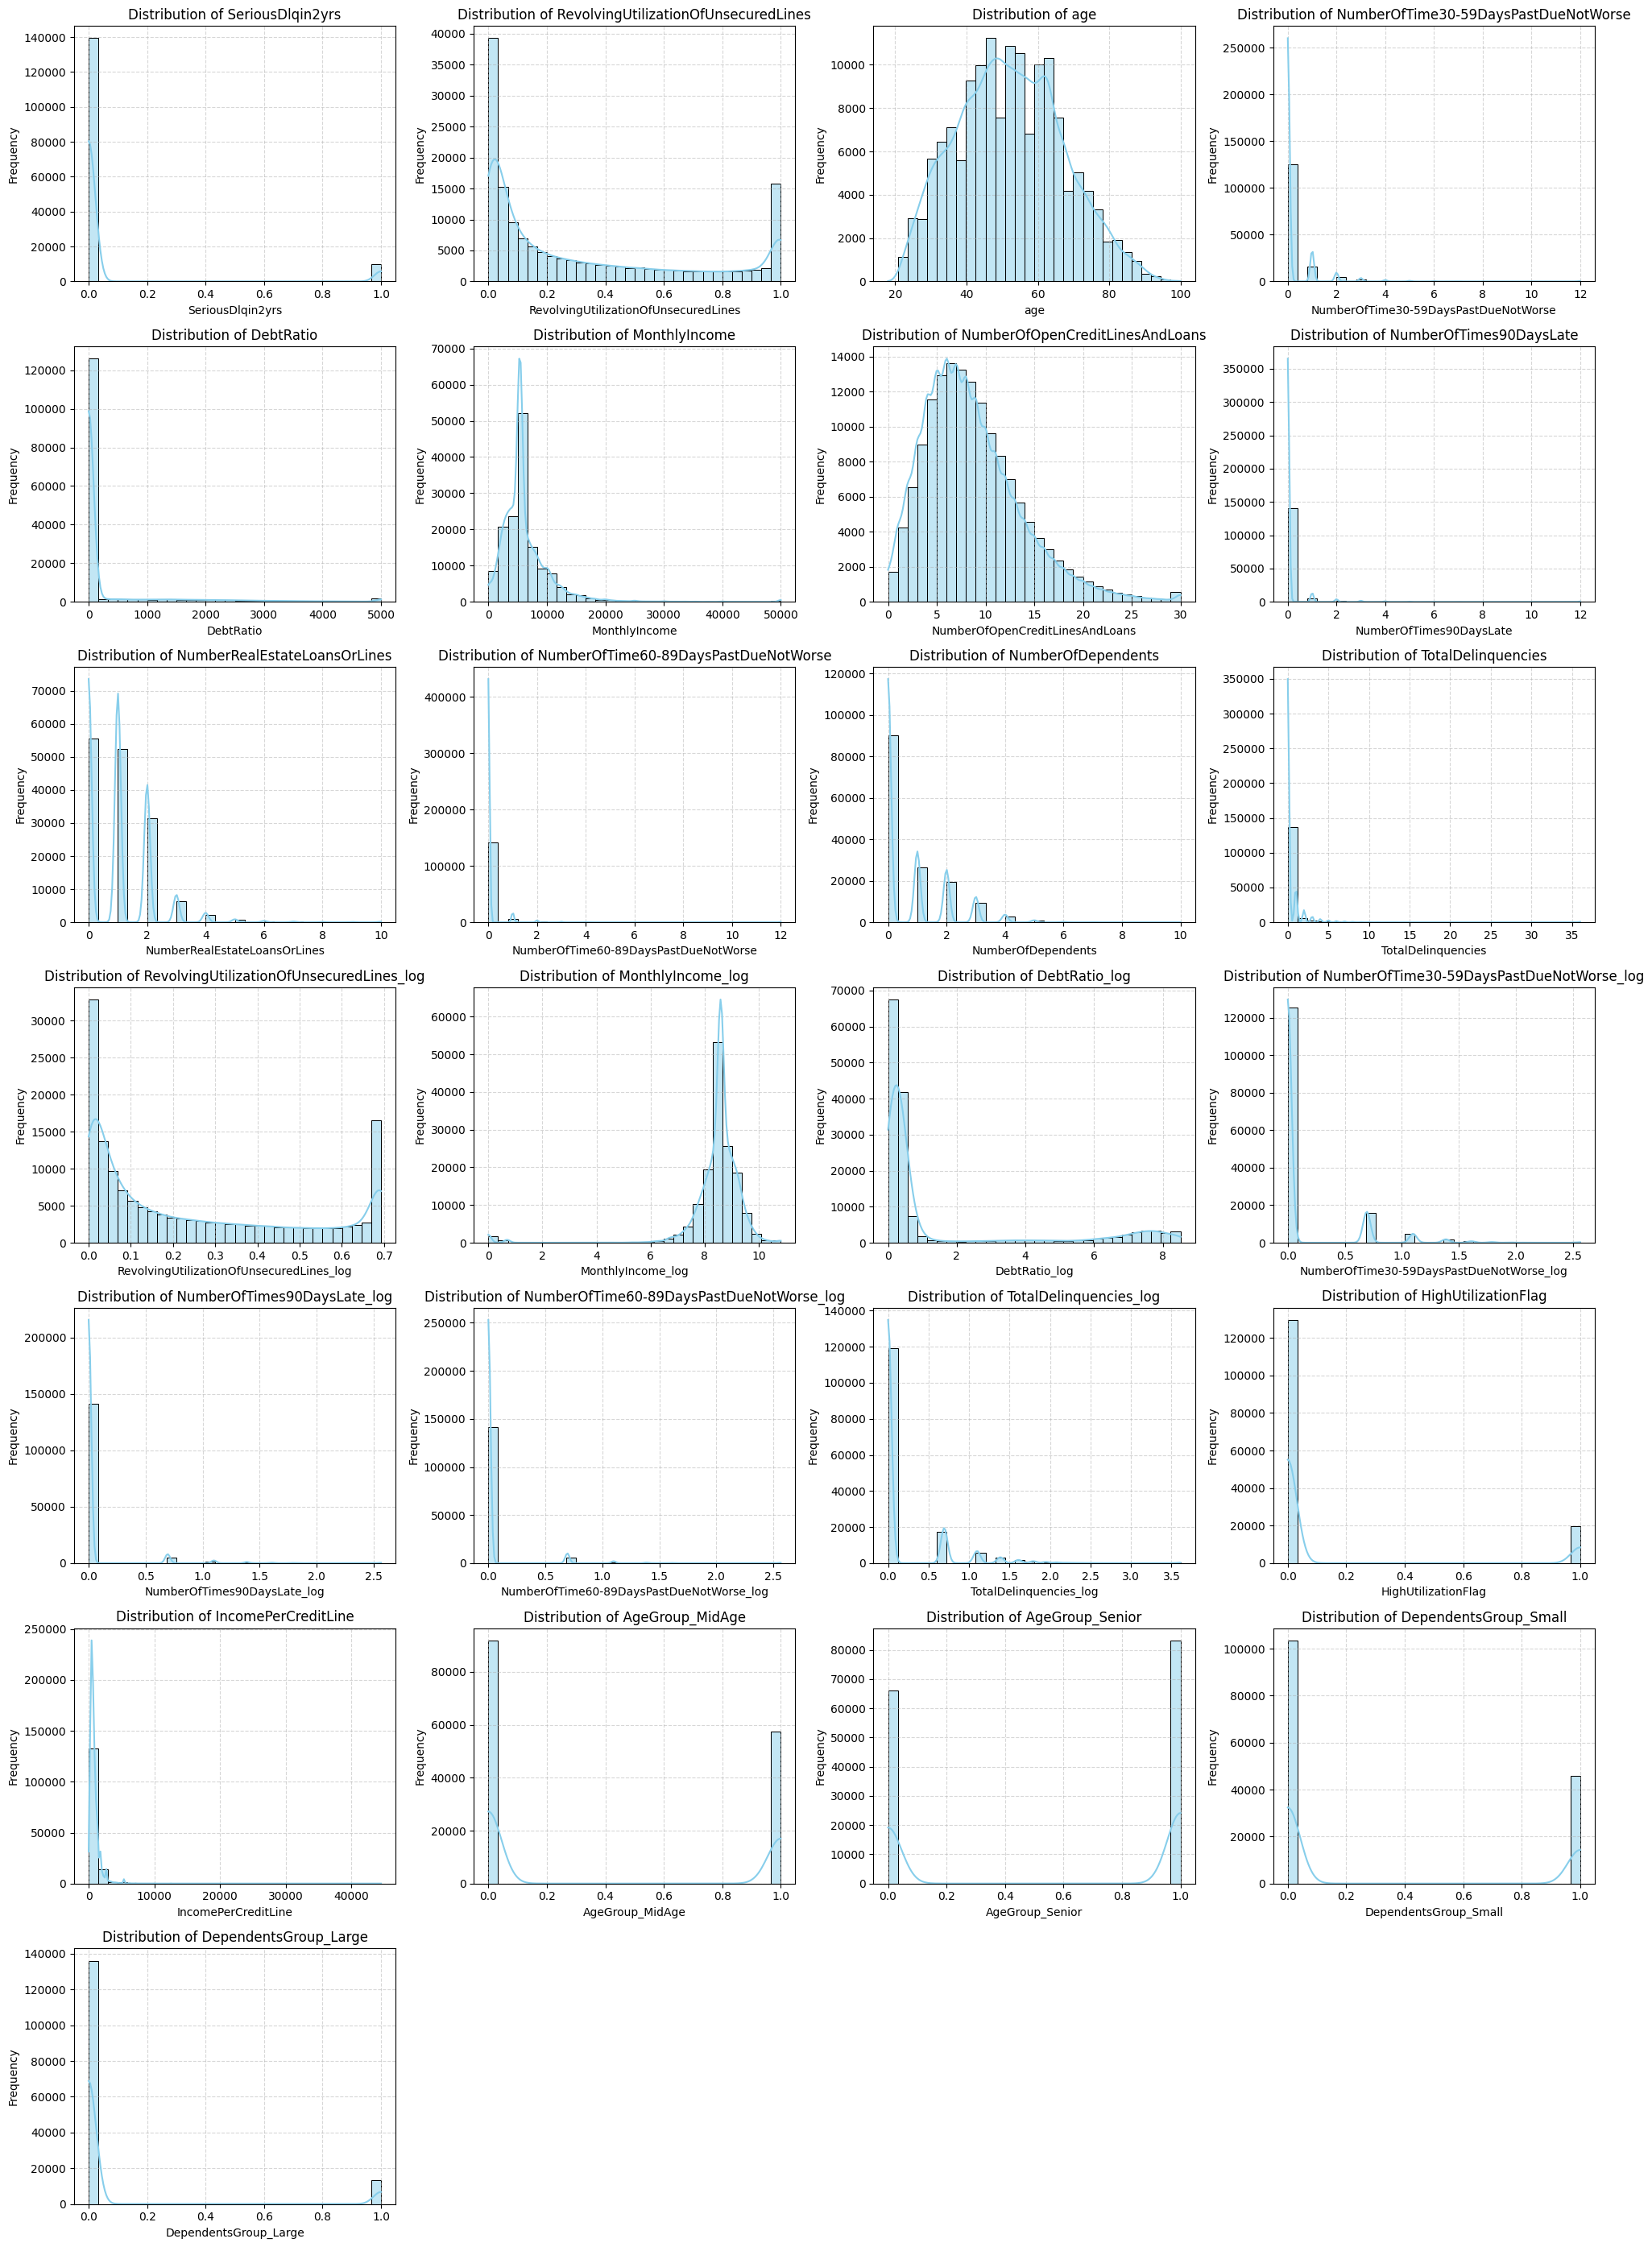

Skewness of numeric features:
 NumberOfTime60-89DaysPastDueNotWorse        15.307031
TotalDelinquencies                          13.349480
NumberOfTimes90DaysLate                     11.821936
IncomePerCreditLine                          7.155159
NumberOfTime30-59DaysPastDueNotWorse         6.640326
NumberOfTime60-89DaysPastDueNotWorse_log     6.070943
NumberOfDependents_missing_flag              6.004405
NumberOfTimes90DaysLate_log                  5.545083
MonthlyIncome                                3.791160
SeriousDlqin2yrs                             3.463772
DebtRatio                                    3.348415
DependentsGroup_Large                        2.881019
NumberOfTime30-59DaysPastDueNotWorse_log     2.702624
TotalDelinquencies_log                       2.610227
HighUtilizationFlag                          2.170124
NumberRealEstateLoansOrLines                 1.882420
DebtRatio_log                                1.734579
NumberOfDependents                           1.5886

In [ ]:
plot_numeric_distributions(df_baseline)
print_skewness(df_baseline)

### Feature Distribution Observations (Baseline Dataset)

- Log transformations effectively reduced extreme skewness in many originally skewed features:
  - `MonthlyIncome_log`: skewness reduced from `126.89` → `-4.99`
  - `RevolvingUtilizationOfUnsecuredLines_log`: from `97.43` → `0.71`
  - `DebtRatio_log`: from `94.98` → `1.73`
  - `Delinquency-related logs` (e.g. `..._log`, `TotalDelinquencies_log`) also show significant improvement

- Some features remain skewed even after transformation, notably:
  - `NumberOfTime60-89DaysPastDueNotWorse_log` (`6.07`)
  - `NumberOfTimes90DaysLate_log` (`5.55`)
  - These likely retain high skew due to a large proportion of zeros and sparse high outliers

- Engineered features such as:
  - `IncomePerCreditLine` (`7.16`)
  - `TotalDelinquencies` (`13.35`)
  - `HighUtilizationFlag` (`2.17`)  
  still display noticeable skewness and may require further treatment depending on model choice.

- Features like `age` (`0.19`), `AgeGroup_MidAge` (`0.47`), and `RevolvingUtilizationOfUnsecuredLines_log` (`0.71`) are relatively symmetric.

Implication:
While transformations reduced skewness substantially, some engineered or log-transformed variables remain skewed due to structural data properties.

## Target Value Distribution

Target variable 'SeriousDlqin2yrs' distribution (counts and proportions):
                   count  proportion
SeriousDlqin2yrs                    
0                 139382    0.933001
1                  10009    0.066999


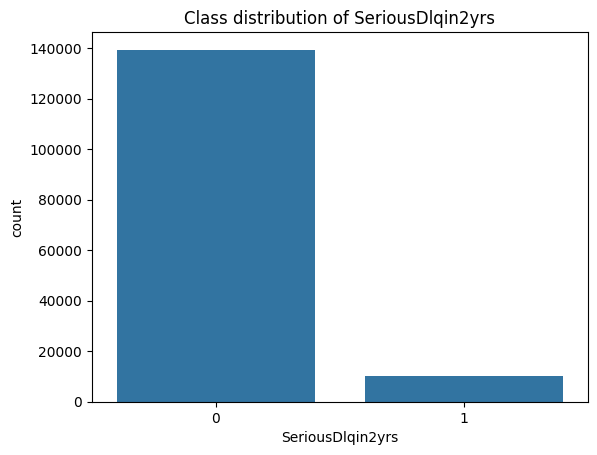

In [ ]:
plot_target_distribution(df_baseline)

### Target Variable Distribution Observations (Baseline Dataset)

The target variable `SeriousDlqin2yrs` remains unchanged after preprocessing. Its distribution is therefore consistent with the raw dataset, showing a significant class imbalance with approximately 6.7% positive cases.

## Correlation Matrix Heatmap

We visualise feature correlations using a heatmap to identify strong relationships and potential multicollinearity among variables.

In [ ]:
plot_correlation_matrix(df_baseline)

### Correlation Matrix Analysis

- The target variable `SeriousDlqin2yrs` shows **moderate positive correlations** with several delinquency-related features, indicating these are strong risk indicators:
  - `TotalDelinquencies_log` (≈ 0.39)
  - `NumberOfTimes90DaysLate_log` (≈ 0.35)
  - `NumberOfTime30-59DaysPastDueNotWorse_log` (≈ 0.29)
  - `NumberOfTime60-89DaysPastDueNotWorse_log` (≈ 0.28)

- The original and log-transformed utilization ratio features both show **positive correlations** with default risk:
  - `RevolvingUtilizationOfUnsecuredLines` (≈ 0.28)
  - `RevolvingUtilizationOfUnsecuredLines_log` (≈ 0.27)

- `HighUtilizationFlag` also has a notable **positive correlation** with the target (~0.25), reinforcing that maxed-out credit utilisation is a risk factor.

- **Age-related features** have weak to moderate **negative correlations** with default, implying older individuals tend to have lower default risk:
  - `age`
  - `AgeGroup_MidAge`
  - `AgeGroup_Senior`

- Several pairs of log-transformed delinquency features exhibit **very strong positive correlations** (> 0.7), indicating multicollinearity:
  - `NumberOfTimes90DaysLate_log` and `TotalDelinquencies_log` (≈ 0.7+)
  - `NumberOfTime30-59DaysPastDueNotWorse_log` and `NumberOfTime60-89DaysPastDueNotWorse_log` (≈ 0.86)

- Features related to dependents have **low correlations** with default and other features, suggesting less direct influence:
  - `DependentsGroup_Large`
  - `NumberOfDependents`

### Implications

- The strong correlations between delinquency features and the target affirm their **importance for predicting default risk**.

- The presence of **multicollinearity** among these features should be addressed, e.g., via feature selection, dimensionality reduction, or regularization during modeling.

- Age and utilization features appear relevant but with weaker associations, indicating that a **combination of financial behavior and demographics drives risk**.

## Conclusion & Next Steps

### Summary of Key EDA Findings

- **Missingness**: Addressed via targeted imputation strategies after analyzing patterns in both raw and baseline datasets. Variables with excessive missingness were dropped to preserve data quality.
- **Outliers & Skewness**: Detected using distribution plots and boxplots. Applied log-transformations and feature engineering to normalize key variables, reducing the influence of extreme values.
- **Target Variable**: The target (`SeriousDlqin2yrs`) is **imbalanced** (~6.7% positive class), motivating the use of appropriate metrics (e.g. ROC-AUC, PR-AUC) and resampling or algorithmic solutions.
- **Feature Relationships**:
  - Correlation analysis revealed weak linear relationships, which benefits tree-based models but necessitates feature selection for linear models.
  - Several engineered features (e.g., `DebtIncomeRatio`, `MonthlyDebt`) show improved separability across classes.

---

### Modeling Roadmap

Next, we move to **baseline modeling and model development**, where we will:

1. **Train-Test Split**: Stratify the imbalanced target to preserve class distribution.
2. **Baseline Models**:
   - Start with interpretable models (e.g., Logistic Regression).
   - Use tree-based models (Random Forest, XGBoost) for performance benchmarks.
3. **Evaluation**:
   - Focus on ROC-AUC, PR-AUC, and F1-score.
   - Use Stratified K-Fold cross-validation for robust estimates.
4. **Feature Importance & Interpretability**:
   - Apply permutation importance, and model-specific methods.
5. **Hyperparameter Tuning**:
   - Use `GridSearchCV` with cross-validation.
